In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
import pickle

%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
RUNS = 100
method_list = ['random_arm', 'random_data', 'random_arm_informed', 'random_data_informed', 'ts_uniform', 'ts_informed']
method_format = {'random_arm': ('Random Arm', 'b', '.', '--'), 
                 'random_data': ('Random Data', 'g', '^', '--'), 
                 'random_arm_informed': ('Random Arm Informative', 'b', '.', '-'), 
                 'random_data_informed': ('Random Data Informative', 'g', '^', '-'), 
                 'ts_uniform': ('TS Uninformative', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),
                }
DATASET_LIST = ['cifar100', 'dbpedia', '20newsgroup', 'svhn', 'imagenet'] #'imagenet', 


In [2]:
metric = 'groupwise_accuracy'
group_method = 'predicted_class' # score_equal_size
pseudocount_list = [100,10,5,2,1,0.1,0.01]
pseudocount = 2
TOPK = False
output = pathlib.Path("../output/%s/" % metric )

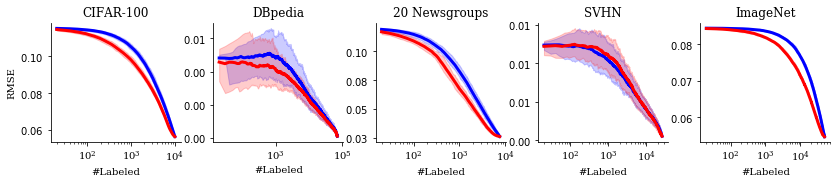

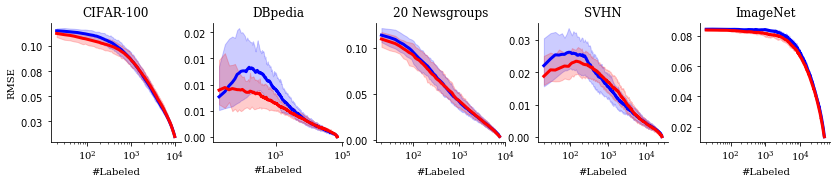

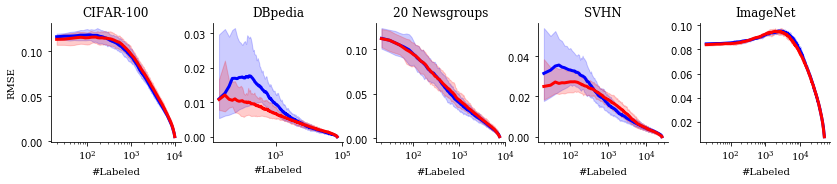

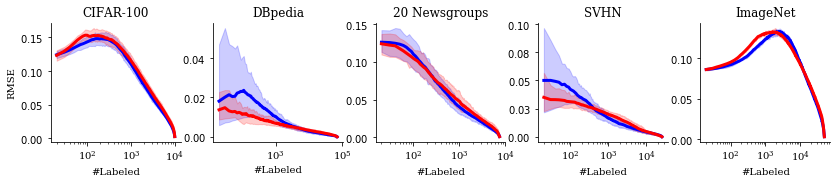

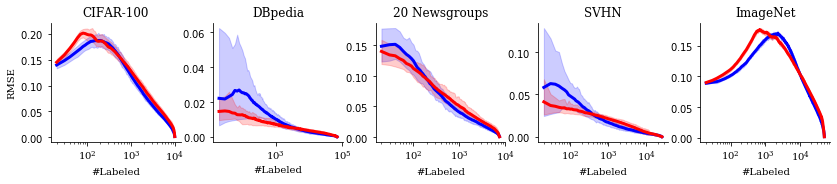

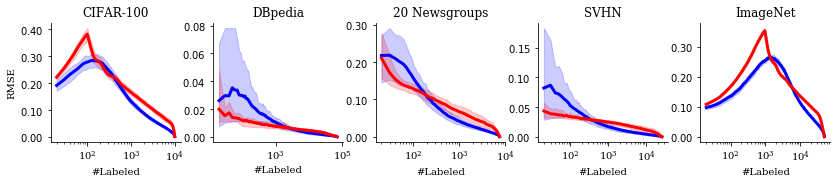

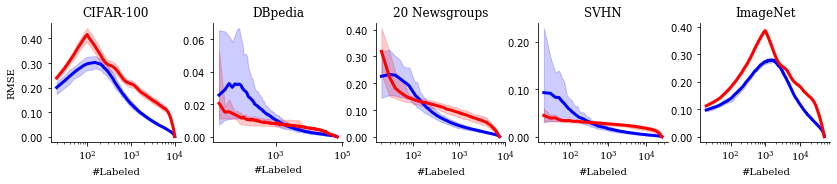

In [3]:
for pseudocount in pseudocount_list:
    
    # load results and compute ground truth
    ground_truth = {}
    l2_error = {}
    l1_ece = {} # L1 ECE
    l2_ece = {} # L2 ECE
    avg_num_agreement = {}
    mrr = {}

    for dataset_name in DATASET_LIST:
        if TOPK:
            topk = TOPK_DICT[args.dataset_name]
        else:
            topk = 1
        experiment_name = '%s_groupby_%s_top%d_pseudocount%.2f' % (dataset_name, group_method, topk, pseudocount)
        ground_truth[dataset_name] = pickle.load(open(output / experiment_name / "ground_truth.pkl", "rb"))  
        l2_error[dataset_name] = pickle.load(open(output / experiment_name / "l2_error.pkl", "rb"))
        l1_ece[dataset_name] = pickle.load(open(output / experiment_name / "l1_ece.pkl", "rb")) 
        l2_ece[dataset_name] = pickle.load(open(output / experiment_name / "l2_ece.pkl", "rb"))  
        if metric in ['most_accurate', 'least_accurate']:
            avg_num_agreement[dataset_name] = pickle.load(open(output / experiment_name / "avg_num_agreement.pkl", "rb"))  
            mrr[dataset_name] = pickle.load(open(output / experiment_name / "mrr.pkl", "rb"))  

    method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                     #'random_data': ('Random Uninformative', 'b', '^', '--'), 
                     #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                     'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                     #'ts_uniform': ('TS Uninformative', 'k', '*', '-'), 
                     'ts_informed': ('TS Informative', 'r', '+', '-'),}


    fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2), 
                            gridspec_kw = {'wspace':0.25, 'hspace':0})
    for i, dataset_name in enumerate(DATASET_LIST):
        start = 1
        num_steps = l2_error[dataset_name]['ts_informed'].shape[1] - 1
        stepsize = 1
        for method_name in method_format:
            legend_name, color, marker, linestyle = method_format[method_name]    
            xrange = np.arange(num_steps) * LOG_FREQ  + LOG_FREQ
            idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
            axes[i].plot(xrange[idx], 
                     np.mean(l2_error[dataset_name][method_name], axis=0)[idx], 
                     label=legend_name, linewidth=3, color=color, linestyle=linestyle)
            if method_name != 'random_data':
                axes[i].fill_between(xrange[idx], 
                             np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                             np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                             color=color, alpha=.2)
            #plt.ylim([0, 0.3])
        axes[i].set_xlabel('#Labeled')
        axes[i].set_xscale('log')
        axes[i].set_title(DATASET_NAMES[dataset_name])

        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
        vals = axes[i].get_yticks()
        axes[i].set_yticklabels(['{:.3f}'.format(x) for x in vals])
        vals = axes[i].get_yticks()
        axes[i].set_yticklabels(['${:.2f}$'.format(x) for x in vals])

    #axes[-1].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.4, 1))
    axes[0].set_ylabel('RMSE')

    plt.tight_layout()           

In [4]:
for pseudocount in pseudocount_list:
    
    method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                     'random_data': ('Random Uninformative', 'b', '^', '--'), 
                     #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                     'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                     #'ts_uniform': ('TS Uninformative', 'k', '*', '-'), 
                     'ts_informed': ('TS Informative', 'r', '+', '-'),}
    
    # load results and compute ground truth
    ground_truth = {}
    l2_error = {}
    l1_ece = {} # L1 ECE
    l2_ece = {} # L2 ECE
    avg_num_agreement = {}
    mrr = {}
    
    counts = dict()

    for dataset_name in DATASET_LIST:
        if TOPK:
            topk = TOPK_DICT[args.dataset_name]
        else:
            topk = 1
        experiment_name = '%s_groupby_%s_top%d_pseudocount%.2f' % (dataset_name, group_method, topk, pseudocount)
        ground_truth[dataset_name] = pickle.load(open(output / experiment_name / "ground_truth.pkl", "rb"))  
        l2_error[dataset_name] = pickle.load(open(output / experiment_name / "l2_error.pkl", "rb"))
        l1_ece[dataset_name] = pickle.load(open(output / experiment_name / "l1_ece.pkl", "rb")) 
        l2_ece[dataset_name] = pickle.load(open(output / experiment_name / "l2_ece.pkl", "rb"))  

    
    for i, dataset_name in enumerate(DATASET_LIST):
        if dataset_name == 'imagenet':
            RUNS = 10
        else:
            RUNS = 100
        counts[dataset_name] = {}
        for method_name in method_format: 
            counts[dataset_name][method_name] = []
            for r in range(RUNS):
                rmse = l2_error[dataset_name][method_name][r]
                counts[dataset_name][method_name].append(np.argmax(rmse < 0.05)*LOG_FREQ+LOG_FREQ)
    
    val = np.zeros((len(DATASET_LIST), len(method_format)))
    for i, dataset_name in enumerate(DATASET_LIST):
        tmp = []
        for method_name in method_format:
            tmp.append(np.mean(counts[dataset_name][method_name]))
        val[i] = np.array(tmp)
    df = pd.DataFrame(val.T, 
                      index=[method_format[i][0] for i in method_format], 
                      columns=[DATASET_NAMES[dataset_name] for dataset_name in DATASET_LIST])
    
    print(df)

                      CIFAR-100  DBpedia  20 Newsgroups  SVHN  ImageNet
Random Uninformative     4121.5     64.8          700.3  87.1   27941.0
Random Informative         10.0     10.0         3103.1  10.0      10.0
TS Informative             10.0     10.0         2052.1  10.0      10.0
                      CIFAR-100  DBpedia  20 Newsgroups  SVHN  ImageNet
Random Uninformative     4106.8     69.6          706.8  88.8   27802.0
Random Informative       3591.4     10.0          638.9  10.1   22089.0
TS Informative           3782.1     10.0          661.0  10.1   20795.0
                      CIFAR-100  DBpedia  20 Newsgroups  SVHN  ImageNet
Random Uninformative     4122.8     62.5          705.7  85.7   27969.0
Random Informative       3694.8     10.5          598.1  14.6   23900.0
TS Informative           4013.7     10.0          700.0  10.9   23972.0
                      CIFAR-100  DBpedia  20 Newsgroups  SVHN  ImageNet
Random Uninformative     4141.3     61.1          715.3  87.8   

In [5]:
# load results and compute ground truth
ground_truth = {}
l2_error = {}
l1_ece = {} # L1 ECE
l2_ece = {} # L2 ECE
avg_num_agreement = {}
mrr = {}

for dataset_name in DATASET_LIST:
    if TOPK:
        topk = TOPK_DICT[args.dataset_name]
    else:
        topk = 1
    experiment_name = '%s_groupby_%s_top%d_pseudocount%.2f' % (dataset_name, group_method, topk, pseudocount)
    ground_truth[dataset_name] = pickle.load(open(output / experiment_name / "ground_truth.pkl", "rb"))  
    l2_error[dataset_name] = pickle.load(open(output / experiment_name / "l2_error.pkl", "rb"))
    l1_ece[dataset_name] = pickle.load(open(output / experiment_name / "l1_ece.pkl", "rb")) 
    l2_ece[dataset_name] = pickle.load(open(output / experiment_name / "l2_ece.pkl", "rb"))  
    if metric in ['most_accurate', 'least_accurate']:
        avg_num_agreement[dataset_name] = pickle.load(open(output / experiment_name / "avg_num_agreement.pkl", "rb"))  
        mrr[dataset_name] = pickle.load(open(output / experiment_name / "mrr.pkl", "rb"))  
    

# plot

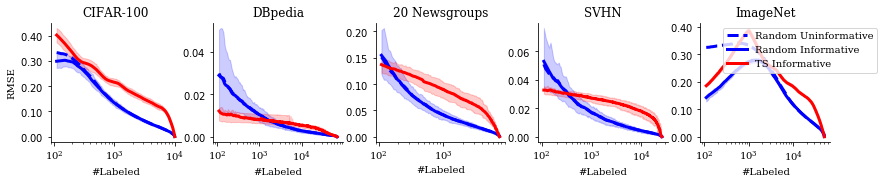

In [6]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random Uninformative', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Uninformative', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2), 
                        gridspec_kw = {'wspace':0.25, 'hspace':0})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 10
    num_steps = l2_error[dataset_name]['ts_informed'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ  + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean(l2_error[dataset_name][method_name], axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        if method_name != 'random_data':
            axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['{:.3f}'.format(x) for x in vals])
    vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['${:.2f}$'.format(x) for x in vals])
    
axes[-1].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.4, 1))
axes[0].set_ylabel('RMSE')

plt.tight_layout()

In [7]:
if TOPK:
    fig.savefig('../figures/groupwise_error_rmse_%s_%s_topk_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)
else:
    fig.savefig('../figures/groupwise_error_rmse_%s_%s_top1_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)   

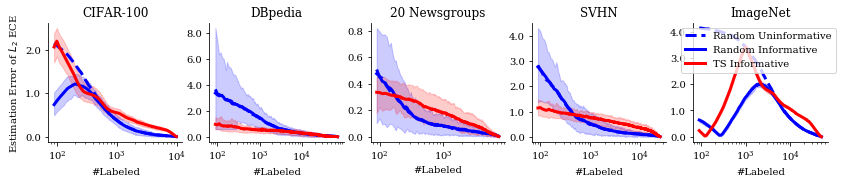

In [8]:
# plot
ece = l1_ece
fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 8
    num_steps = ece[dataset_name]['ts_informed'].shape[1] - start
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        ece_error = np.abs(ece[dataset_name][method_name] \
                           - ece[dataset_name]['ts_informed'][0][-1]) / ece[dataset_name]['ts_informed'][0][-1]
        axes[i].plot(xrange[idx], 
                 np.mean(ece_error, axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        if method_name != 'random_data':
            axes[i].fill_between(xrange[idx], 
                             np.quantile(ece_error, 0.125, axis=0)[idx], 
                             np.quantile(ece_error, 0.875, axis=0)[idx], 
                             color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['{:.1f}'.format(x) for x in vals])
    
axes[-1].legend(fontsize=10, loc='upper right', bbox_to_anchor=(1.1, 1))
axes[0].set_ylabel('Estimation Error of $L_2$ ECE ')
plt.tight_layout()

In [9]:
if TOPK:
    fig.savefig('../figures/l2_ece_%s_%s_topk_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)
else:
    fig.savefig('../figures/l2_ece_%s_%s_top1_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)   

# MRR

KeyError: 'cifar100'

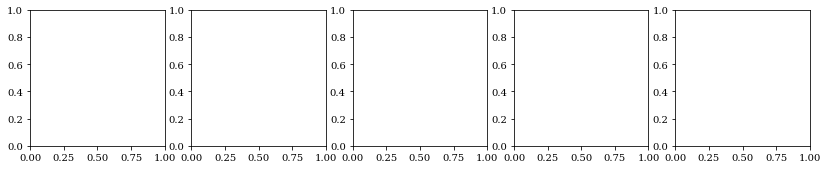

In [11]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.5),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = min(mrr[dataset_name][method_name].shape[0],
                   np.argmax(np.mean(mrr[dataset_name]['ts_informed'], axis=1) > 0.99) + 40)
    num_steps = max(num_steps, int(mrr[dataset_name][method_name].shape[0]*0.6))- start
    stepsize = 10
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                     np.mean(mrr[dataset_name][method_name], axis=1)[idx], 
                     label=legend_name, linewidth=3, color=color, linestyle=linestyle)
#        axes[i].fill_between(xrange[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.125, axis=1)[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.875, axis=1)[idx], 
#                          color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    # axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    # axes[i].set_ylim(0,1)
axes[-1].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel('MRR')

In [ ]:
if TOPK:
    fig.savefig('../figures/mrr_%s_%s_topk_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)
else:
    fig.savefig('../figures/mrr_%s_%s_top1_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)    

In [ ]:
# plot
fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.5),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 1
    num_steps = min(avg_num_agreement[dataset_name][method_name].shape[0],
                   np.argmax(avg_num_agreement[dataset_name]['ts_informed'] > 0.999)+ 40)
    num_steps = max(num_steps, int(avg_num_agreement[dataset_name][method_name].shape[0]*0.1))- start
    stepsize = 10
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                     avg_num_agreement[dataset_name][method_name][idx], 
                     label=legend_name, linewidth=3, color=color, linestyle=linestyle)
#         axes[i].fill_between(xrange[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.125, axis=1)[idx], 
#                          np.quantile(mrr[dataset_name][method_name], 0.875, axis=1)[idx], 
#                          color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    #axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[-1].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel('Success Rate')

In [ ]:
if TOPK:
    fig.savefig('../figures/success_rate_%s_%s_topk_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)
else:
    fig.savefig('../figures/success_rate_%s_%s_top1_pseudocount%d.pdf' % (metric, group_method, pseudocount*100), \
            dpi=300, bbox_inches='tight', pad_inches=0)  